In [2]:
####################### LIBRARIES ####################################
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from torchvision import datasets, transforms 
import torchvision.models as models 

import numpy as np 
from random import sample 
import matplotlib.pyplot as plt 

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='./data' , train=False, transform = transforms.ToTensor())

total_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

normal_dataset = sample([total_dataset.__getitem__(idx) 
                         for idx in range(len(total_dataset))
                          if total_dataset.__getitem__(idx)[1] == 5], 6000)
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out
    
    def get_codes(self, x):
        return self.encoder(x)

In [7]:
def train(model, Loss, optimizer, num_epochs):
    train_loss_arr = []
    test_loss_arr = []
    
    best_test_loss = 9999999999
    early_stop, early_stop_max = 0., 3.
    
    for epoch in range(num_epochs):
        
        epoch_loss = 0.
        
        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            
            # Forward Pass 
            model.train()
            outputs = model(batch_X)
            train_loss = Loss(outputs, batch_X)
            epoch_loss += train_loss.data
            
            # Backward and optimize
            train_loss.backward()
            optimizer.step()
            
        train_loss_arr.append(epoch_loss/len(train_loader.dataset))
        
        if epoch % 10 == 0:
            model.eval()
            test_loss = 0.
            
            for batch_X, _ in test_loader:
                batch_X = batch_X.to(device)
                
                outputs = model(batch_X)
                batch_loss = Loss(outputs, batch_X)
                test_loss += batch_loss.data
                
            test_loss = test_loss 
            test_loss_arr.append(test_loss)
            
            if best_test_loss > test_loss : 
                best_test_loss = test_loss
                early_stop = 0
                
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f} *'.format(epoch, num_epochs, epoch_loss, test_loss))
            else:
                early_stop += 1
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch, num_epochs, epoch_loss, test_loss)) 
        
        if early_stop >= early_stop_max : 
            break

In [10]:
AE = AutoEncoder(28 * 28, 64, 32)
AE_loss = nn.MSELoss()

device = torch.device('cpu')
AE = AE.to(device)

learning_rate = 0.01
num_epochs = 150

AE_optimizer = optim.Adam(AE.parameters(), lr = learning_rate)


train(AE, AE_loss, AE_optimizer, num_epochs)

Epoch [0/150], Train Loss: 6.0454, Test Loss: 0.7331 *
Epoch [10/150], Train Loss: 2.9475, Test Loss: 0.4879 *
Epoch [20/150], Train Loss: 2.8125, Test Loss: 0.4790 *
Epoch [30/150], Train Loss: 2.7640, Test Loss: 0.4768 *
Epoch [40/150], Train Loss: 2.7130, Test Loss: 0.4607 *
Epoch [50/150], Train Loss: 2.6920, Test Loss: 0.4565 *
Epoch [60/150], Train Loss: 2.6754, Test Loss: 0.4557 *
Epoch [70/150], Train Loss: 2.6636, Test Loss: 0.4476 *
Epoch [80/150], Train Loss: 2.6629, Test Loss: 0.4546
Epoch [90/150], Train Loss: 2.6515, Test Loss: 0.4530
Epoch [100/150], Train Loss: 2.6575, Test Loss: 0.4499


torch.Size([1, 28, 28])


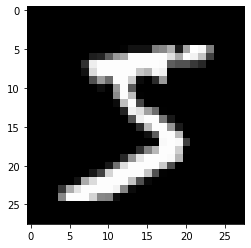

In [18]:
tmp = train_dataset[0]
x, y = tmp
print(x.shape)

plt.imshow(x.reshape(28, 28), cmap='gray')

In [20]:
code = AE.get_codes(x.view(x.size(0), -1))
print(code)

tensor([[1.0308, 0.6472, 0.0000, 2.2127, 0.5764, 1.3150, 0.0000, 1.6310, 3.0726,
         1.0362, 0.0000, 0.0000, 1.4157, 0.0000, 2.1901, 0.0000, 1.7740, 0.3798,
         0.0000, 0.0000, 0.5365, 0.0000, 0.0000, 0.0000, 0.0000, 0.6264, 0.0000,
         0.0000, 0.5842, 1.4740, 1.4636, 0.0000]], grad_fn=<ReluBackward0>)


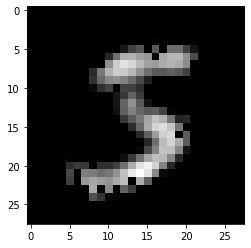

In [25]:
recon = AE.forward(x)
recon = recon.detach().numpy()
plt.imshow(recon.reshape(28, 28), cmap='gray')

In [26]:
import cv2

torch.Size([1, 28, 28])
torch.Size([1, 32])


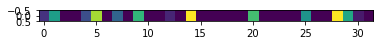

In [55]:
edges = cv2.Laplacian(recon, -1)
edges = torch.Tensor(edges)
print(edges.shape)
tmp = AE.get_codes(edges.view(1, -1))
print(tmp.shape)
plt.imshow(tmp.detach().numpy())

In [31]:
from pathlib import Path
image_path = Path('oduck/.jpg')

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[128 125 151]
  [ 97  97 121]
  [112 115 136]
  ...
  [250 248 247]
  [252 248 247]
  [252 250 249]]

 [[112 110 140]
  [108 109 137]
  [114 117 138]
  ...
  [249 247 246]
  [249 247 246]
  [250 248 247]]

 [[108 106 136]
  [109 110 138]
  [182 185 206]
  ...
  [248 246 245]
  [248 246 245]
  [249 247 246]]]


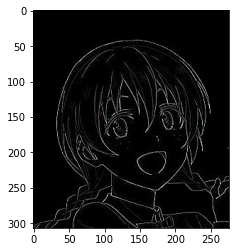

In [38]:
img = cv2.imread('oduck.jpg')
print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.Laplacian(img, -1)
plt.imshow(img)

In [96]:
class NoiseEdgeAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim1, hidden_dim2):
    super(NoiseEdgeAutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU()
    )
    self.noise = np.random.normal(0, 1, hidden_dim2)
    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim2, hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1, input_dim),
        nn.ReLU()
    )
    self.edgeExtract = nn.Sequential(
    
    )

  def edgeDetect(self, x):
    edges = []
    
    for item in x:
        edge =cv2.Laplacian(item, -1)
        edges.append(edge)
    edges = torch.Tensor(np.array(edges))
    return edges

  def forward(self, x):
    out = x.view(x.size(0), -1)
    
    edge = x.numpy()
    edge = self.edgeDetect(edge)
    edge = edge.view(edge.size(0), -1)

    out = self.encoder(out)
    edge = self.encoder(edge)

    out = out + torch.Tensor(self.noise) + edge

    out = self.decoder(out)
    out = out.view(x.size())
    return out

  def get_codes(self, x):
    return self.encoder(x)

In [97]:
NEAE = NoiseEdgeAutoEncoder(28 * 28, 64, 32)
NEAE.to(device)

loss = nn.MSELoss()
optimizer = optim.Adam(NEAE.parameters(), lr=0.01)
train(NEAE, loss, optimizer, 10)

KeyboardInterrupt: 